# CNN for time series, exercise project 3 - Netflix

## Dependancies

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# if your Jupyter kernel crashes during this code, use this setting
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/Netflix Dataset.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [4]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5540.000000,5540.000000,5540.000000,5540.000000,5540.000000,5.540000e+03
mean,140.532640,142.672456,138.337011,140.561354,140.561354,1.569438e+07
std,182.387899,184.938036,179.723418,182.376297,182.376297,1.862414e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,4.165893,4.245714,4.080000,4.163036,4.163036,5.751000e+06
50%,35.942858,36.778572,35.346429,36.154285,36.154285,9.830450e+06
75%,282.360008,287.464989,275.742500,282.892502,282.892502,1.859220e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.234140e+08


In [6]:
df = df.drop(['Low', 'Close', 'Adj Close', 'Open'], axis=1)

In [7]:
df.head()

,Date,High,Volume
0,2002-05-23,1.242857,104790000
1,2002-05-24,1.225000,11104800
2,2002-05-28,1.232143,6609400
3,2002-05-29,1.164286,6757800
4,2002-05-30,1.107857,10154200


In [8]:
scaler = MinMaxScaler()
num_cols = ['Volume', 'High']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [9]:
df.head()

,Date,High,Volume
0,2002-05-23,0.001188,0.323414
1,2002-05-24,0.001162,0.033483
2,2002-05-28,0.001172,0.019571
3,2002-05-29,0.001076,0.020030
4,2002-05-30,0.000995,0.030541


In [10]:
# instead of the date-column and old index,
# let's use a sequence number
# starting from 1 until the final row
df['sequence'] = df.index + 1
df = df.drop('Date', axis=1)

In [11]:
df.tail()

,High,Volume,sequence
5535,0.919181,0.011055,5536
5536,0.928473,0.008153,5537
5537,0.926147,0.005851,5538
5538,0.916812,0.006277,5539
5539,0.930072,0.007204,5540


## Split the DataFrame into timesteps

In [12]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 20

# separate the output variables
open = df['Volume'].values
high = df['High'].values

# generate timestep windows for each signal
open_windows = sliding_window_view(open, window_shape=timestep_size)
high_windows = sliding_window_view(high, window_shape=timestep_size)

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((open_windows, high_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(open_windows) + [1] * len(high_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (11042, 20)
y: (11042,)


In [13]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

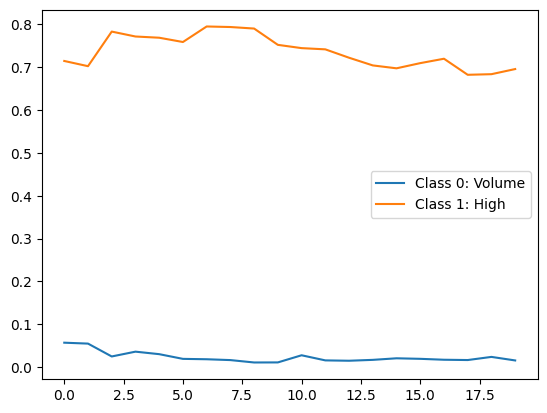

In [14]:
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: Volume")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: High")
plt.legend()

 Finally we can do the train/test split

In [15]:
 # define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [16]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

7729
3313
7729
3313


In [17]:
x_train

array([[0.02874461, 0.05475409, 0.04438267, ..., 0.023322  , 0.02141471,
        0.04356906],
       [0.00764571, 0.00819628, 0.00829416, ..., 0.00856944, 0.00848787,
        0.00848583],
       [0.00449934, 0.00484803, 0.0048725 , ..., 0.00497038, 0.00504582,
        0.00500096],
       ...,
       [0.03725591, 0.03701937, 0.03751488, ..., 0.04930104, 0.04934998,
        0.04871989],
       [0.01792229, 0.01559721, 0.01678218, ..., 0.01249596, 0.01731541,
        0.01156723],
       [0.04630079, 0.02643129, 0.02862361, ..., 0.03859518, 0.03862768,
        0.02222213]])

In [18]:
# convert the data into the required CNN -format
# usuallu the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [19]:
x_train

array([[[0.02874461],
        [0.05475409],
        [0.04438267],
        ...,
        [0.023322  ],
        [0.02141471],
        [0.04356906]],

       [[0.00764571],
        [0.00819628],
        [0.00829416],
        ...,
        [0.00856944],
        [0.00848787],
        [0.00848583]],

       [[0.00449934],
        [0.00484803],
        [0.0048725 ],
        ...,
        [0.00497038],
        [0.00504582],
        [0.00500096]],

       ...,

       [[0.03725591],
        [0.03701937],
        [0.03751488],
        ...,
        [0.04930104],
        [0.04934998],
        [0.04871989]],

       [[0.01792229],
        [0.01559721],
        [0.01678218],
        ...,
        [0.01249596],
        [0.01731541],
        [0.01156723]],

       [[0.04630079],
        [0.02643129],
        [0.02862361],
        ...,
        [0.03859518],
        [0.03862768],
        [0.02222213]]])

## First Model

In [20]:
class_names = np.array(["Volume", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [21]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.6696 - val_loss: 0.6065 - val_sparse_categorical_accuracy: 0.6087
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3445 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.5924 - val_sparse_categorical_accuracy: 0.5957
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2332 - sparse_categorical_accuracy: 0.9131 - val_loss: 1.4698 - val_sparse_categorical_accuracy: 0.6831
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9295 - val_loss: 1.2997 - val_sparse_categorical_accuracy: 0.7186
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9315 - val_loss: 2.7360 - val_sparse_categorical_accuracy: 0.6746
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2044 - sparse_categorical_accuracy: 0.9166 - val_loss: 3.2034 - val_sparse_categorical_accuracy: 0.669

<Axes: >

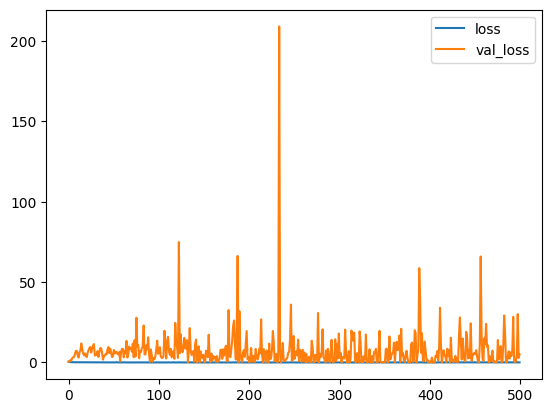

In [22]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

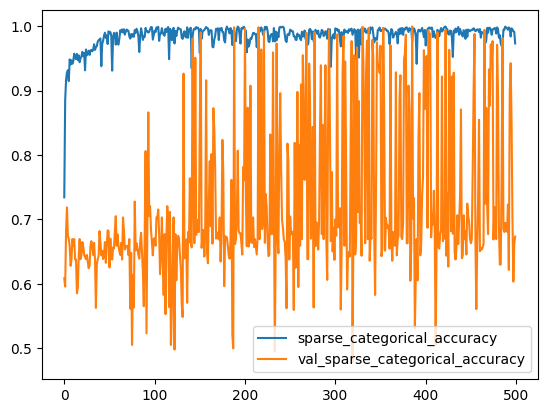

In [23]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [24]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[5.272238254547119, 0.6601267457008362]

Train data evaluation:
[5.058401107788086, 0.6727907657623291]


In [25]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Axes: >

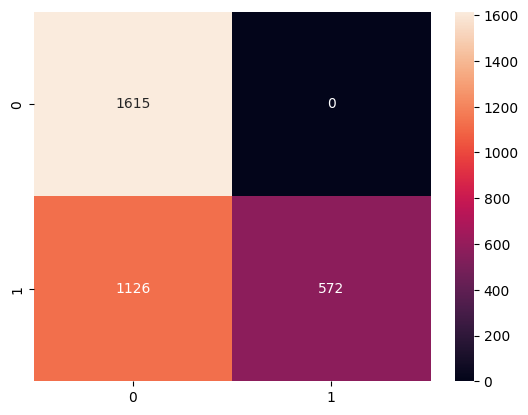

In [26]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [27]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1615
           1       1.00      0.34      0.50      1698

    accuracy                           0.66      3313
   macro avg       0.79      0.67      0.62      3313
weighted avg       0.80      0.66      0.62      3313


Model overall accuracy: 66.01%


Okay! Would you look at that, it still seems to prefer one Class over the other, but to a way lesser extent, we now have an accuracy of 66.01%. Let's try the other models.

## Second Model

In [52]:
class_names = np.array(["Volume", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
        keras.layers.Input(input_shape),
        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        
        # Additional Conv1D layer
        keras.layers.Conv1D(filters=128, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        # Optional: Add a Dropout layer to prevent overfitting
        keras.layers.Dropout(0.3),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),  # Increased number of units
        keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [53]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8273 - val_loss: 2.1421 - val_sparse_categorical_accuracy: 0.4948
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1803 - sparse_categorical_accuracy: 0.9285 - val_loss: 3.0807 - val_sparse_categorical_accuracy: 0.4994
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1581 - sparse_categorical_accuracy: 0.9271 - val_loss: 1.0643 - val_sparse_categorical_accuracy: 0.7050
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.8260
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.8693 - val_sparse_categorical_accuracy: 0.6779
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.6484 - val_sparse_categorical_accuracy: 0.71

<Axes: >

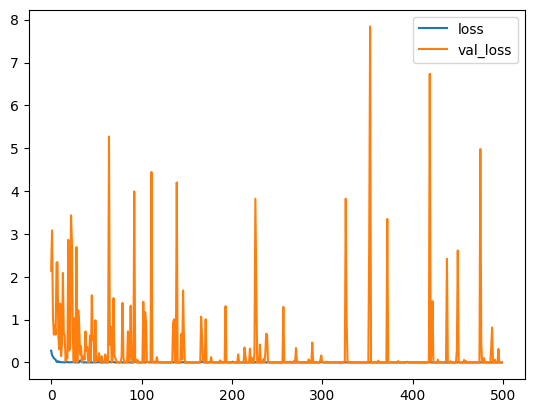

In [54]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

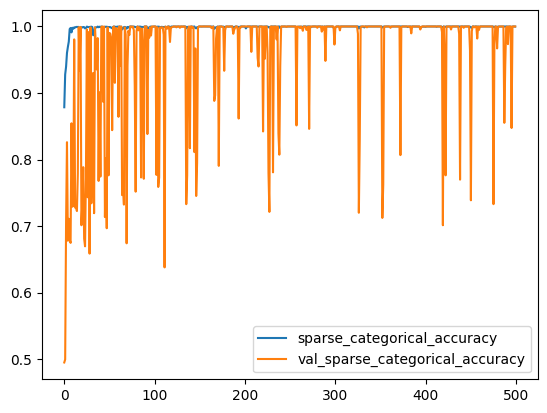

In [55]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [56]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.00018961317255161703, 1.0]

Train data evaluation:
[0.0003838835982605815, 1.0]


In [57]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Axes: >

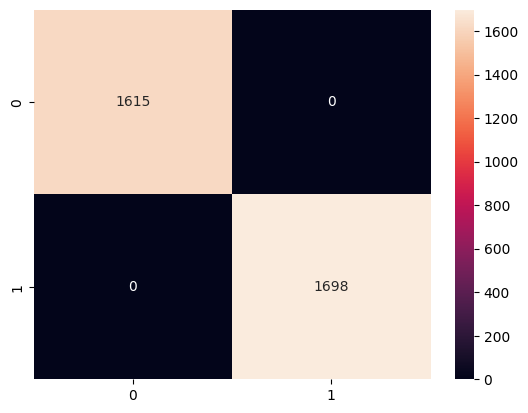

In [58]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [59]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1615
           1       1.00      1.00      1.00      1698

    accuracy                           1.00      3313
   macro avg       1.00      1.00      1.00      3313
weighted avg       1.00      1.00      1.00      3313


Model overall accuracy: 100.00%


Okay this is just straight up 100% accurate, this is really good. However, it could be that this model is just overfitting and is not able to actually make future prediction correctly. Let's test the model.

### Testing the model

1
High


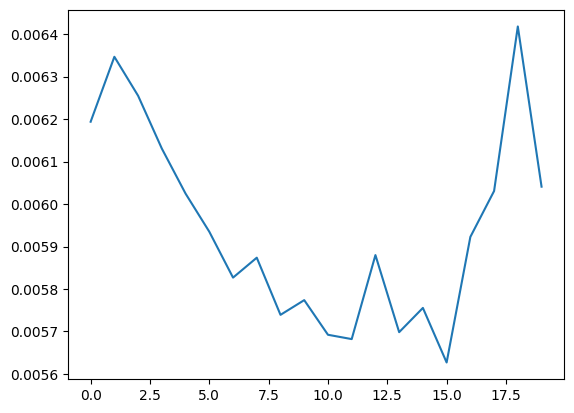

In [60]:
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

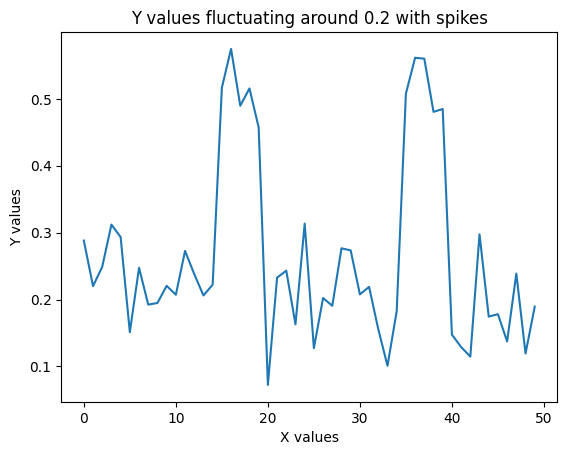

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [62]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
[[1. 0.]]
Volume


In [63]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[1. 0.]]
Volume


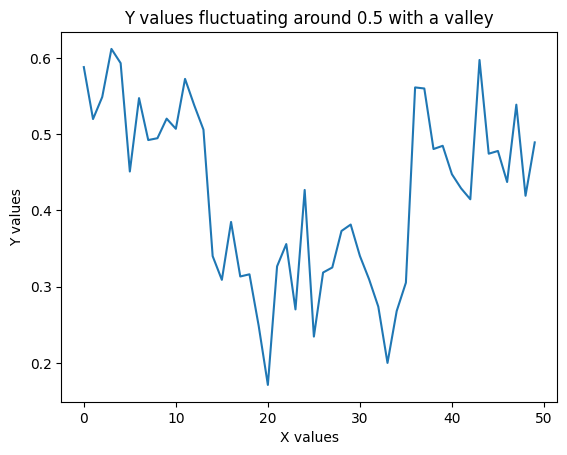

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

# y now contains the desired values

In [65]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
[[1.0000000e+00 1.7318292e-32]]
Volume


## Third Model

In [66]:
class_names = np.array(["Volume", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
    keras.layers.Input(input_shape),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    
    # Additional Conv1D layer
    keras.layers.Conv1D(filters=128, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),

    # Optional: Add a Dropout layer to prevent overfitting
    keras.layers.Dropout(0.3),

    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),  # Increased number of units
    keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

c:\Users\Startklar\Documents\Study\Finnilandi\DeepLearning\DPierdiluca_DL-Repo\.venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [67]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3691 - sparse_categorical_accuracy: 0.8140 - val_loss: 1.2638 - val_sparse_categorical_accuracy: 0.4955
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2294 - sparse_categorical_accuracy: 0.8968 - val_loss: 2.9213 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1624 - sparse_categorical_accuracy: 0.9304 - val_loss: 2.5743 - val_sparse_categorical_accuracy: 0.5440
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.9303 - val_loss: 0.9569 - val_sparse_categorical_accuracy: 0.7025
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9585 - val_loss: 3.3898 - val_sparse_categorical_accuracy: 0.6514
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9769 - val_loss: 2.1137 - val_sparse_categorical_accuracy: 0.68

<Axes: >

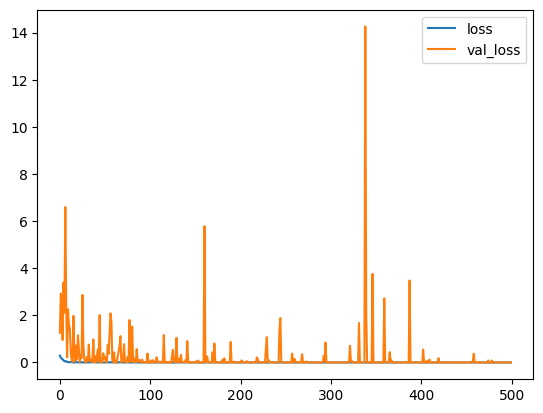

In [68]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

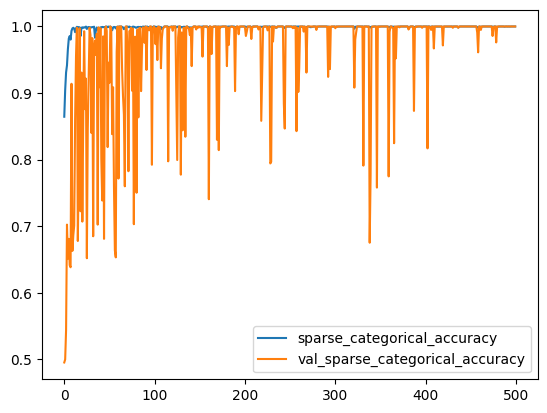

In [69]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [70]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[5.494835022545885e-07, 1.0]

Train data evaluation:
[1.0523096989345504e-06, 1.0]


In [71]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Axes: >

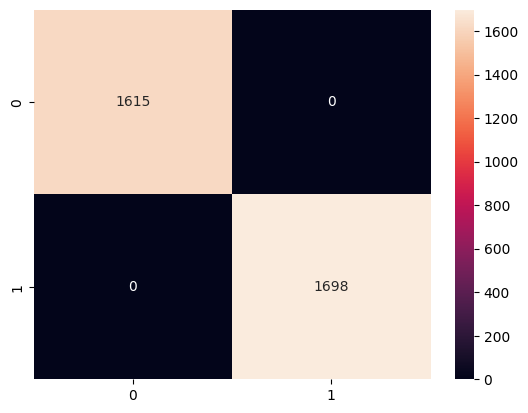

In [72]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [73]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1615
           1       1.00      1.00      1.00      1698

    accuracy                           1.00      3313
   macro avg       1.00      1.00      1.00      3313
weighted avg       1.00      1.00      1.00      3313


Model overall accuracy: 100.00%


This model is also 100% accurate.

### Testing the model

1
High


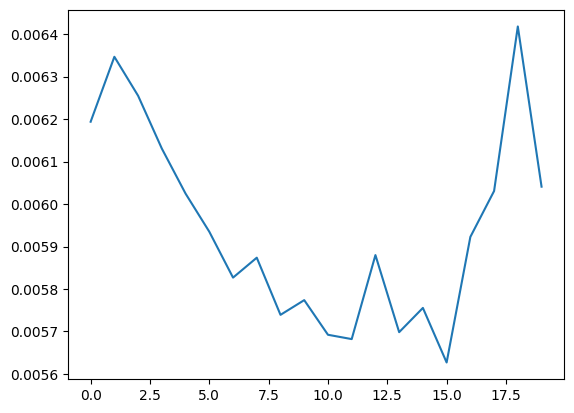

In [74]:
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

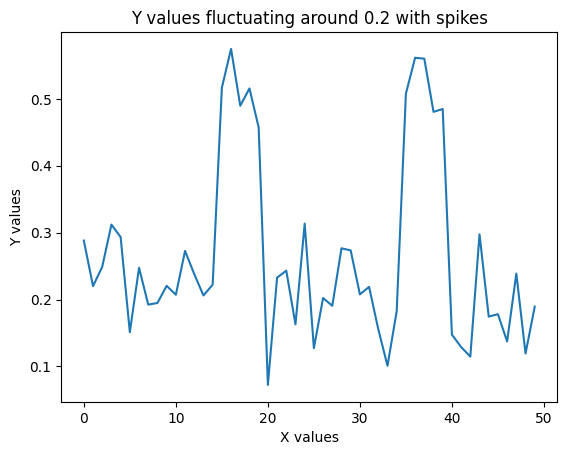

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [76]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[[1. 0.]]
Volume


In [77]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[1. 0.]]
Volume


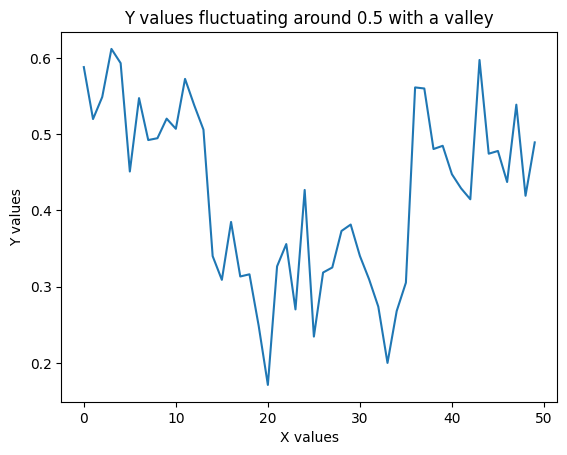

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

# y now contains the desired values

In [79]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[1. 0.]]
Volume


These are the exact same models.

## Fourth Model

In [80]:
class_names = np.array(["Volume", "High"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
        keras.layers.Input(input_shape),
        keras.layers.Conv1D(filters=64, kernel_size=3, padding="same",kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        
        # Additional Conv1D layer
        keras.layers.Conv1D(filters=128, kernel_size=3, padding="same",kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        # Optional: Add a Dropout layer to prevent overfitting
        keras.layers.Dropout(0.3),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),  # Increased number of units
        keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [81]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.4155 - sparse_categorical_accuracy: 0.8349 - val_loss: 1.7155 - val_sparse_categorical_accuracy: 0.4948
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9344 - val_loss: 3.1292 - val_sparse_categorical_accuracy: 0.5032
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9746 - val_loss: 0.8827 - val_sparse_categorical_accuracy: 0.7167
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.7459 - val_sparse_categorical_accuracy: 0.7076
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9928 - val_loss: 2.5174 - val_sparse_categorical_accuracy: 0.6759
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9983 - val_loss: 3.5132 - val_sparse_categorical_accuracy: 0.6

<Axes: >

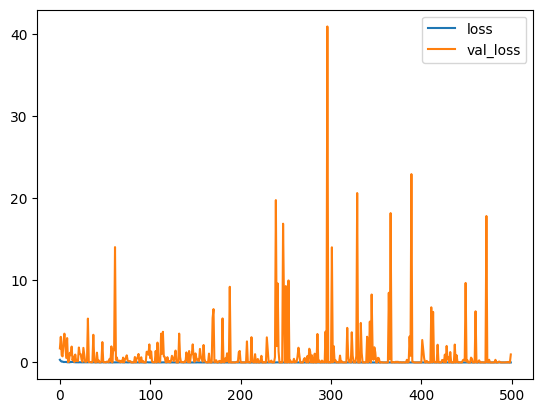

In [82]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

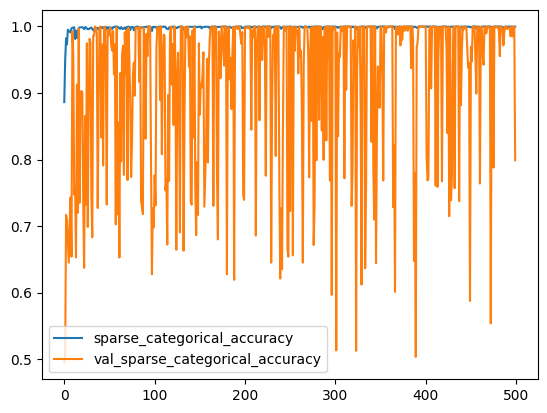

In [83]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [84]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.9817588925361633, 0.7980682253837585]

Train data evaluation:
[0.954701840877533, 0.8033380508422852]


In [85]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Axes: >

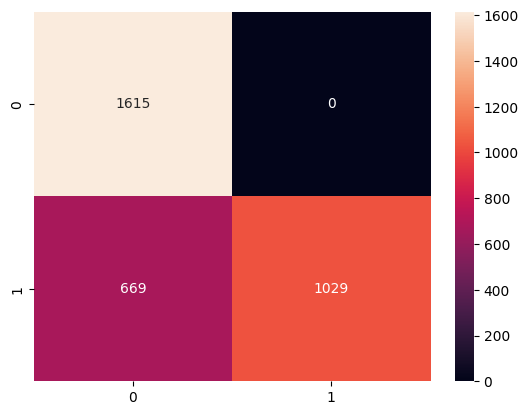

In [86]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [87]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1615
           1       1.00      0.61      0.75      1698

    accuracy                           0.80      3313
   macro avg       0.85      0.80      0.79      3313
weighted avg       0.86      0.80      0.79      3313


Model overall accuracy: 79.81%


### Testing the model

1
High


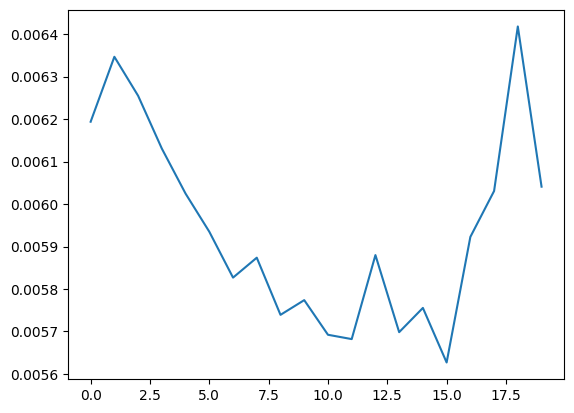

In [88]:
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

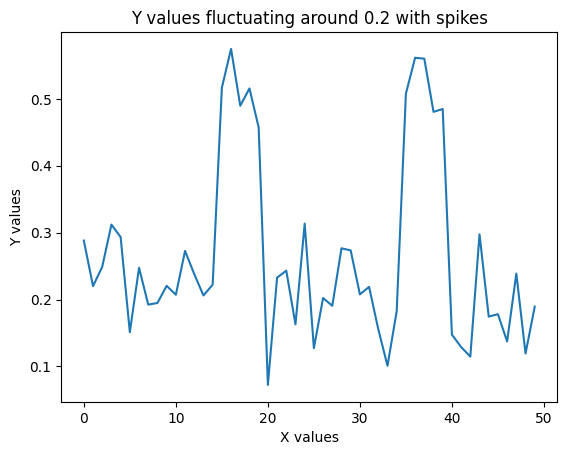

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [90]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
[[1. 0.]]
Volume


In [91]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[1. 0.]]
Volume


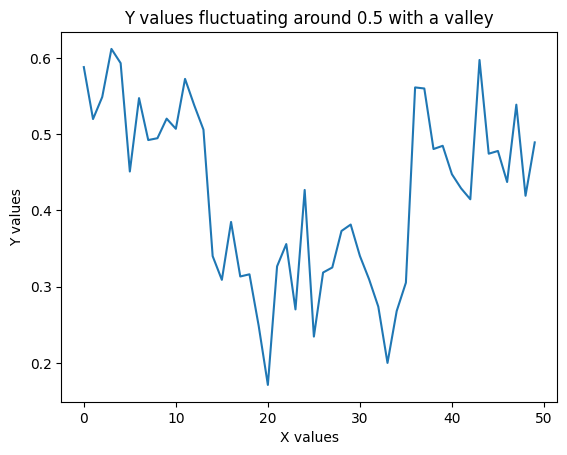

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

# y now contains the desired values

In [93]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[1. 0.]]
Volume


## Conclusion

Nice! We can see that the models work way more accurately when the correlation of the second class is not near-1. The second and third model even had 100% accuracy.<br>
It was very difficult to figure out that the problem of the bad performing models was actually the high correlation of the classes. It's good that I tried out both options, otherwise I would have probably made a lot of models that never really improved.<br>
This model could be used to offer financial analysis to help predict stock prices and trading volumes. This could help traders to make informed decisions. It could also help to signal financial risk by detecting anomalies in trading activity.<br>
I still think that the models may suffer from overfitting, which I cannot really pin down how to find out. It is very suspicious that these models have 100% accuracy without needing much tweaking, but I think I lack the expertise to figure this out. There may be a possibility to add more regularizers or dropout layers to prevent overfitting.<br>
We can see that in the fourth model, where it's accuracy sank down to 79% by introducing regularizers, which may tell us that this is not really the problem, but I am not sure.<br>
We can also see, by looking at the train/test data evaluation, that the second model has very close and similiar values, indicating a good accuracy and no overfitting, while the third model shows to be very off in this regard. The fourth model is again pretty close.<br><br>
I think the possibility exists, that there may be a better model, which is better suited for forecasting, but it would take a lot of minor tweaking and I'm pretty satisfied with the second model.

Although when looking at the train/test data evaluation of the second model:

Test data evaluation:
[0.00018961317255161703, 1.0]

Train data evaluation:
[0.0003838835982605815, 1.0]

I am very concerned about the fact the the y-values are at 1.0, I think this indicates heavy overfitting but I am not sure how to go about this or how to fix this. This may be a problem with the dataset.